Libraries

In [805]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

Importing Dataset

In [806]:
df=pd.read_csv('promoted_Employee_raw.csv')
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


General Informations about data frame

In [807]:
print("Number of row and column:",df.shape)

Number of row and column: (54808, 14)


In [808]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [809]:
#number of unique values for each column in a DataFrame:
df.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

Columns with missing values:

In [810]:
missing_values=df.isnull().sum()
missing_values=missing_values[missing_values>0] # To display only the columns with missing values
missing_values

education               2409
previous_year_rating    4124
dtype: int64

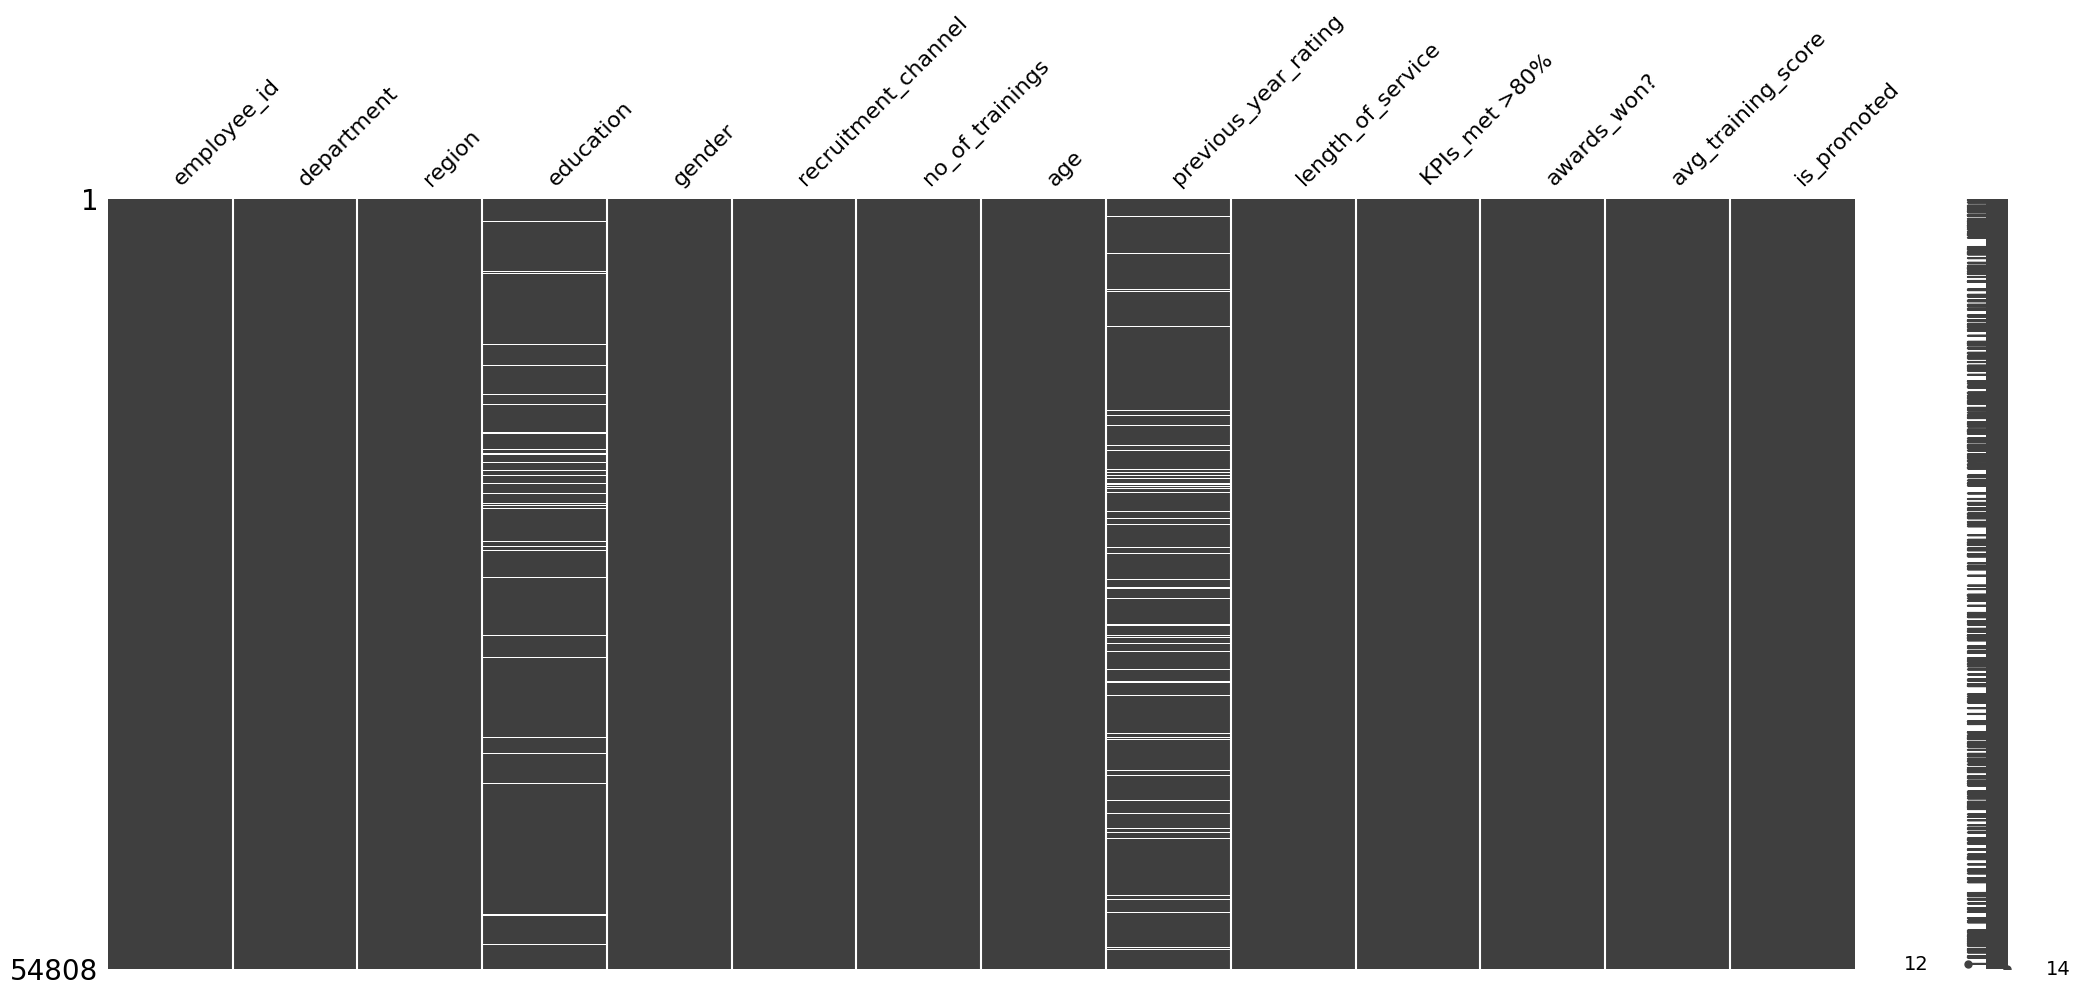

<Figure size 600x400 with 0 Axes>

In [811]:
#display the distribution of missing data
msno.matrix(df)
plt.figure(figsize=(6, 4))
plt.show()

In [812]:
print("Skewness of previous year rating col:",df['previous_year_rating'].skew()) # Measures the asymmetry of the distribution of a column's values.

Skewness of previous year rating col: -0.3106378431385327


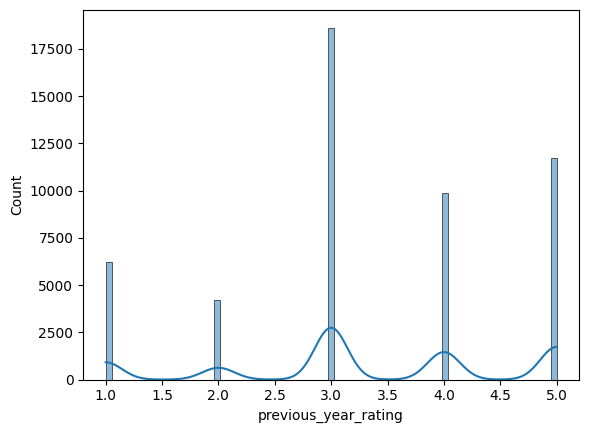

In [813]:
sns.histplot(df['previous_year_rating'], kde=True)
plt.show()

                                                            Define Categories                                                                     

Numerical Cols:

In [814]:
numerical_cols=df.select_dtypes(include=['int64','float64']).columns.to_list()
numerical_cols


['employee_id',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'is_promoted']

Categorical Cols:

In [815]:
categorical_cols=df.select_dtypes(include=['object','category']).columns.to_list()
categorical_cols

['department', 'region', 'education', 'gender', 'recruitment_channel']

Extracting "numerical but categorical" cols from numerical cols:

In [816]:
unique_value_counts = df.nunique()                        
low_variety_cols = unique_value_counts[unique_value_counts < 15].index.tolist()
 #Columns with fewer than 15 unique values are often considered categorical because they do not consist of continuous numerical values.
low_variety_cols

['department',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'previous_year_rating',
 'KPIs_met >80%',
 'awards_won?',
 'is_promoted']

In [817]:
updated_numerical_cols=[col for col in numerical_cols if col not in low_variety_cols]
updated_numerical_cols.remove('employee_id')
print("updated numerical cols:",updated_numerical_cols)


updated numerical cols: ['age', 'length_of_service', 'avg_training_score']


Statistical Overview of Numerical Cols:

In [818]:
df[updated_numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,54808.0,34.803915,7.660169,20.0,29.0,33.0,39.0,60.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.0,5.0,7.0,37.0
avg_training_score,54808.0,63.386750,13.371559,39.0,51.0,60.0,76.0,99.0


Outlier Detection

In [819]:
# Identify outliers for each numerical column in the DataFrame using the interquartile range (IQR) method.
outliers={}
for col in updated_numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

for col, outlier_vals in outliers.items():
    print(f"The outliers in the {col} :\n{outlier_vals}\n")


The outliers in the age :
33       57
42       59
49       56
99       60
307      58
         ..
54580    57
54617    57
54628    57
54749    55
54792    59
Name: age, Length: 1435, dtype: int64

The outliers in the length_of_service :
13       16
42       26
60       17
74       14
99       17
         ..
54691    19
54695    18
54697    15
54754    14
54803    17
Name: length_of_service, Length: 3489, dtype: int64

The outliers in the avg_training_score :
Series([], Name: avg_training_score, dtype: int64)



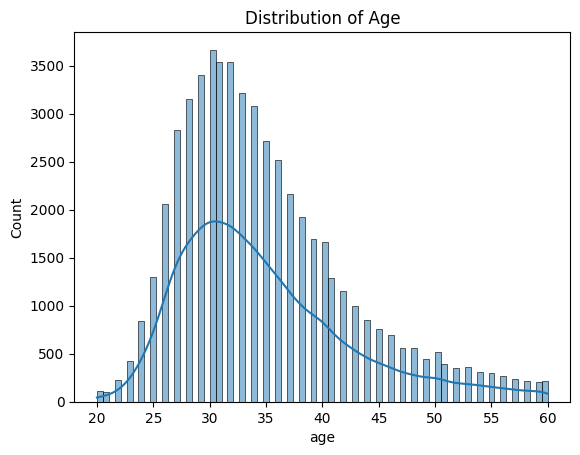

In [820]:
sns.histplot(df['age'], kde=True)
plt.title('Distribution of Age')
plt.show()

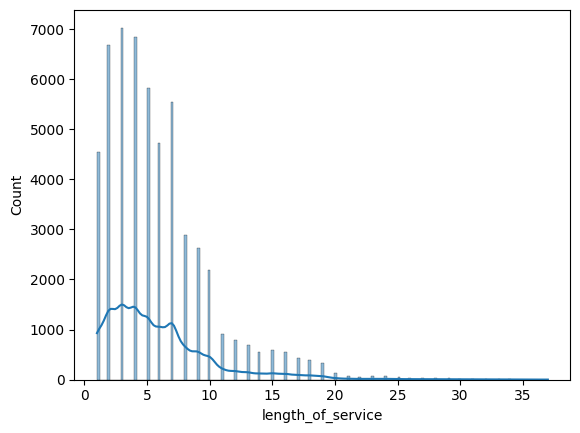

In [821]:
sns.histplot(df['length_of_service'], kde=True)
plt.show()

Relationships between numerical columns

In [822]:
df[updated_numerical_cols].corr() #is a statistical measure that describes the strength and direction of a relationship between two variables.

,age,length_of_service,avg_training_score
age,1.000000,0.657111,-0.048380
length_of_service,0.657111,1.000000,-0.038122
avg_training_score,-0.048380,-0.038122,1.000000


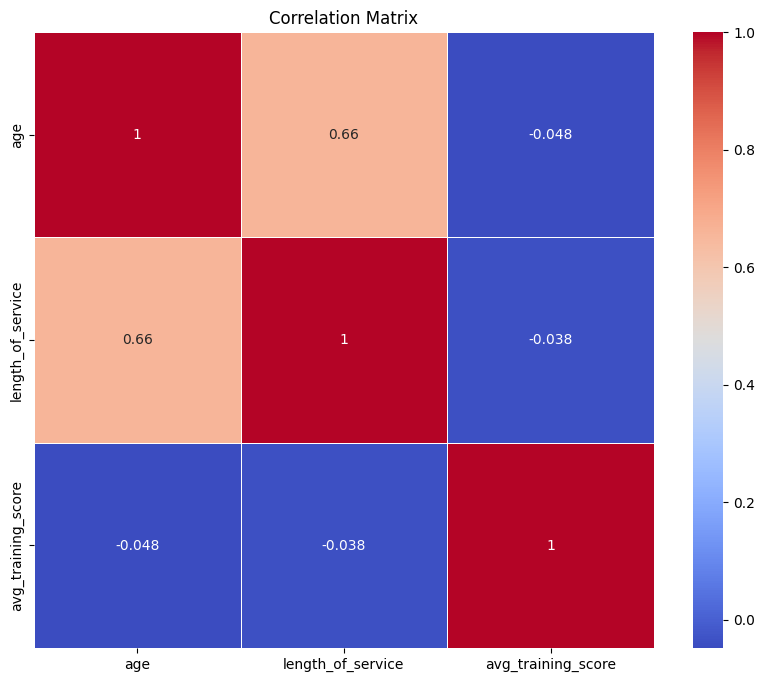

In [823]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[updated_numerical_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

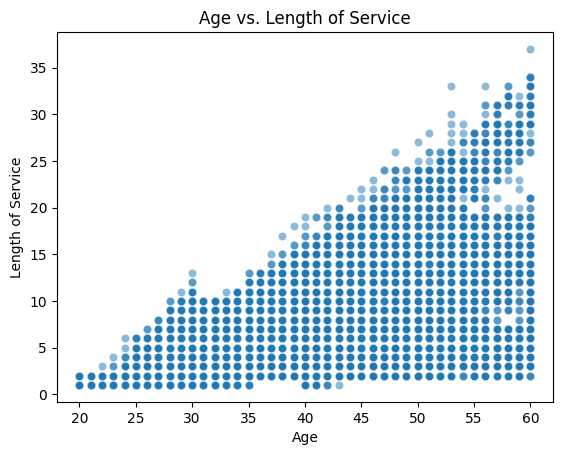

In [824]:
sns.scatterplot(x='age', y='length_of_service', data=df, alpha=0.5)
plt.title('Age vs. Length of Service')
plt.xlabel('Age')
plt.ylabel('Length of Service')
plt.show()

Visualizing data

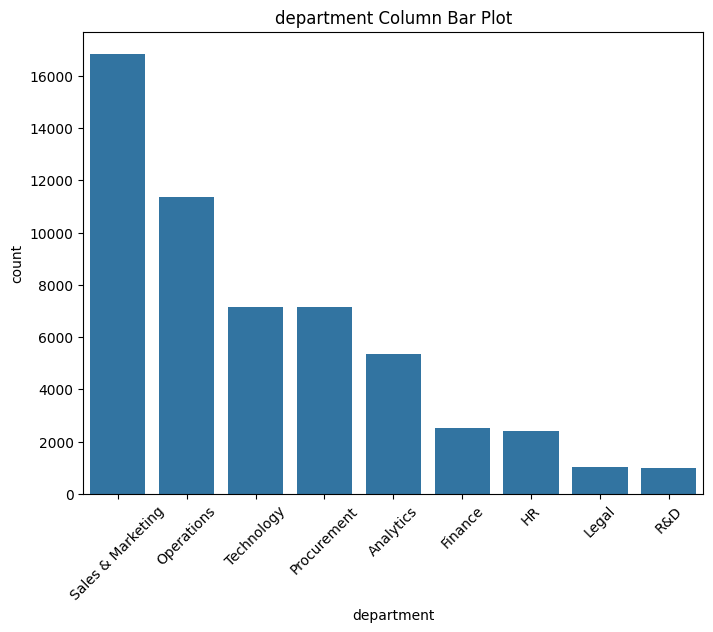

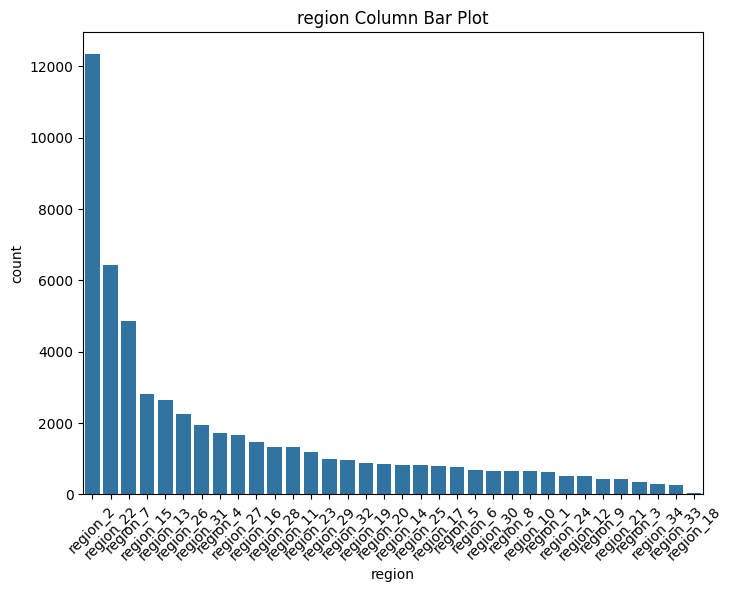

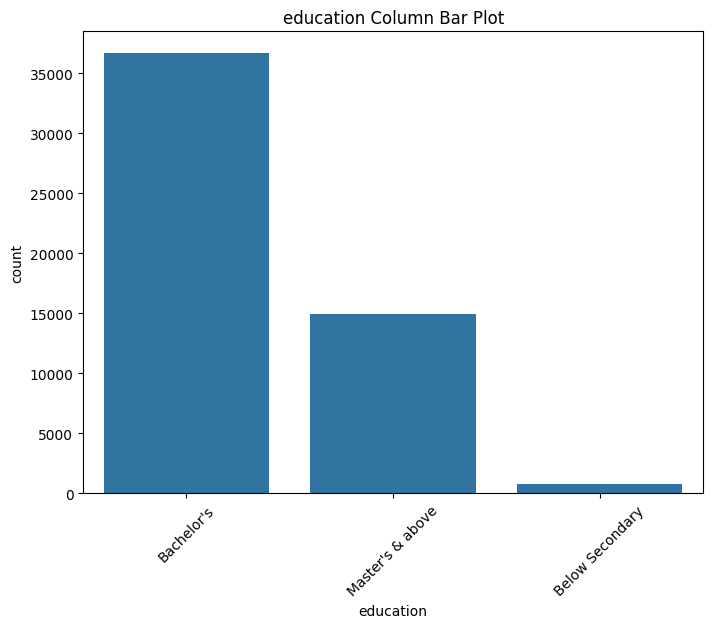

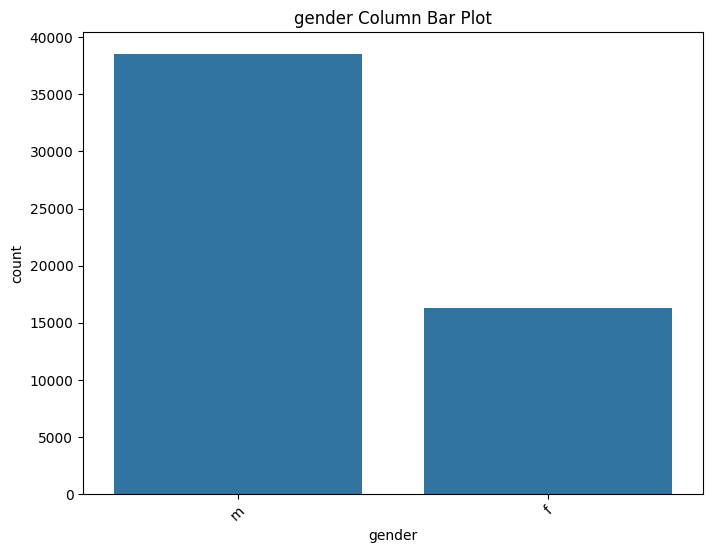

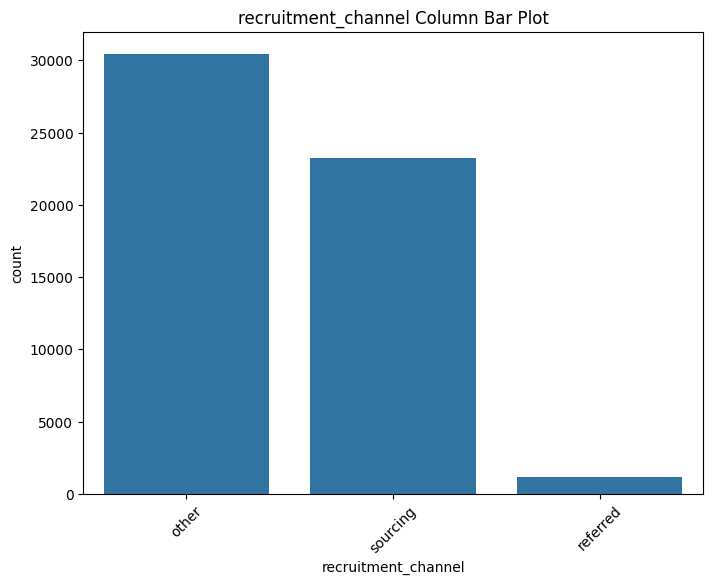

In [825]:
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[col], order=df[col].value_counts().index)  
    plt.title(f'{col} Column Bar Plot')
    plt.xticks(rotation=45) 
    plt.show()

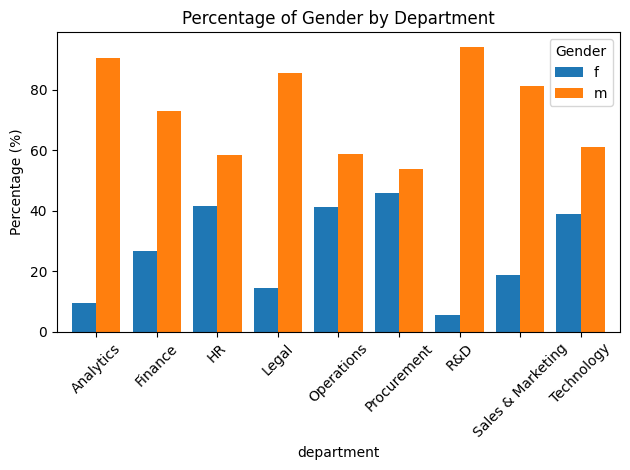

In [826]:
# Grouping by 'department' and 'Gender'
rating_counts = df.groupby(['department', 'gender']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Gender by Department')
plt.xticks(rotation=45)
plt.legend(title='Gender' )
plt.tight_layout()
plt.show()

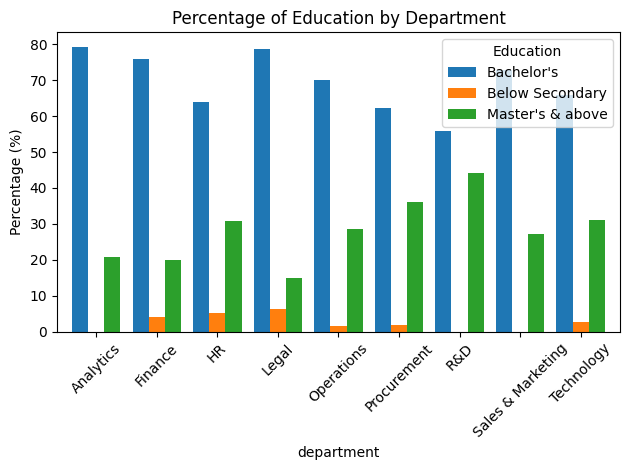

In [827]:
# Grouping by 'department' and 'Education'
rating_counts = df.groupby(['department', 'education']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Education by Department')
plt.xticks(rotation=45)
plt.legend(title='Education' )
plt.tight_layout()
plt.show()

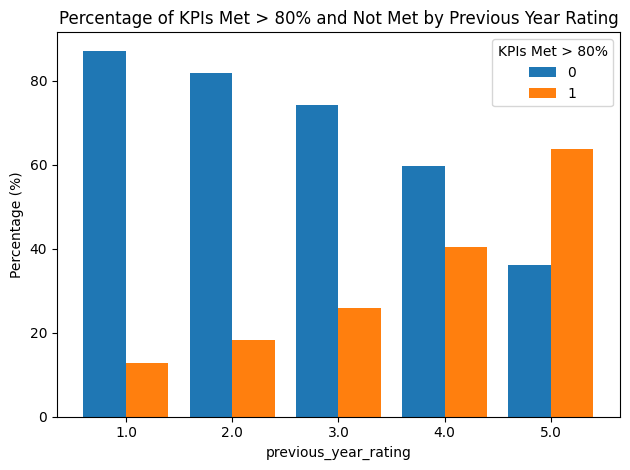

In [828]:
rating_kpis_counts = df.groupby(['previous_year_rating', 'KPIs_met >80%']).size().unstack(fill_value=0)

# Calculate percentages
rating_kpis_percentage = rating_kpis_counts.div(rating_kpis_counts.sum(axis=1), axis=0) * 100

# Bar plot
rating_kpis_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of KPIs Met > 80% and Not Met by Previous Year Rating')
plt.xticks(rotation=0)
plt.legend(title='KPIs Met > 80%')
plt.tight_layout()
plt.show()

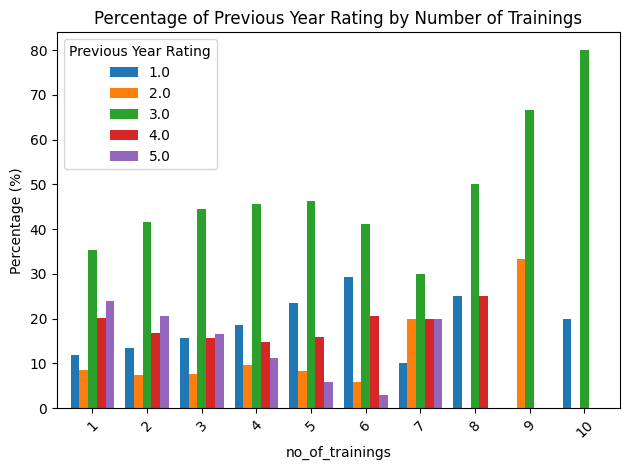

In [829]:
# Grouping by 'no_of_trainings' and 'previous_year_rating'
training_rating_counts = df.groupby(['no_of_trainings', 'previous_year_rating']).size().unstack(fill_value=0)

# Calculate percentages
training_rating_percentage = training_rating_counts.div(training_rating_counts.sum(axis=1), axis=0) * 100

# Bar plot
ax=training_rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Previous Year Rating by Number of Trainings')
plt.xticks(rotation=45)
ax.legend(title='Previous Year Rating')
plt.tight_layout()
plt.show()

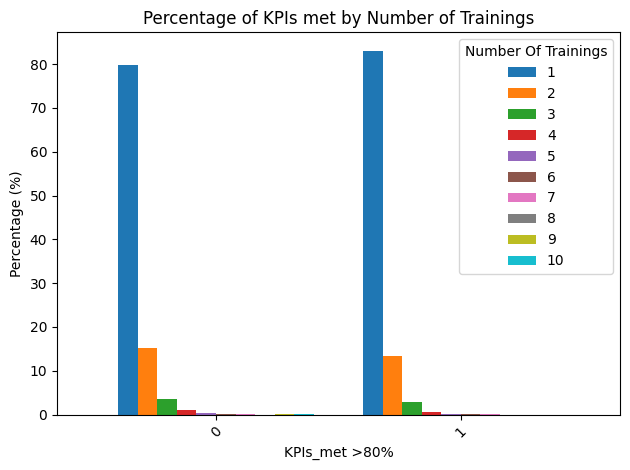

In [830]:
# Grouping by 'no_of_trainings' and 'previous_year_rating'
training_rating_counts = df.groupby(['KPIs_met >80%', 'no_of_trainings']).size().unstack(fill_value=0)

# Calculate percentages
training_rating_percentage = training_rating_counts.div(training_rating_counts.sum(axis=1), axis=0) * 100

# Bar plot
ax=training_rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of KPIs met by Number of Trainings')
plt.xticks(rotation=45)
ax.legend(title='Number Of Trainings')
plt.tight_layout()
plt.show()

In [831]:
df['avg_training_score_group'] = pd.cut(df['avg_training_score'], 
bins=[0, 30, 50, 70, 90, 100], 
labels=['0-30', '30-50', '50-70', '70-90', '90-100'], 
include_lowest=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\398539620.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_counts = df.groupby(['avg_training_score_group', 'no_of_trainings']).size().unstack(fill_value=0)


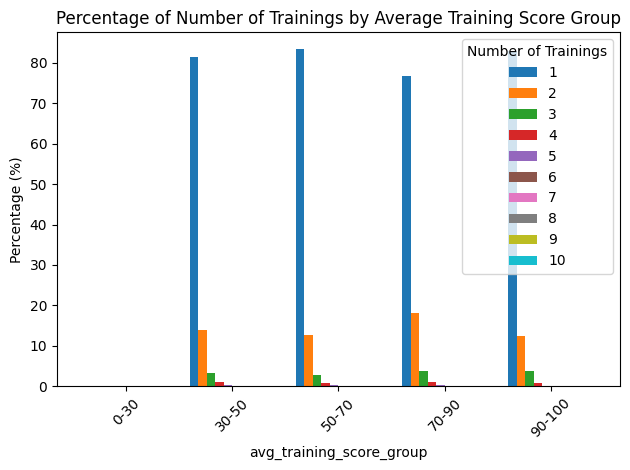

In [832]:
# Grouping by 'avg_training_score_group' and 'no_of_trainings'
score_counts = df.groupby(['avg_training_score_group', 'no_of_trainings']).size().unstack(fill_value=0)

# Calculate percentages
score_percentage = score_counts.div(score_counts.sum(axis=1), axis=0) * 100

# Plotting
score_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Number of Trainings by Average Training Score Group')
plt.xticks(rotation=45)
plt.legend(title='Number of Trainings')
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\4052683237.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_counts = df.groupby(['avg_training_score_group', 'previous_year_rating']).size().unstack(fill_value=0)


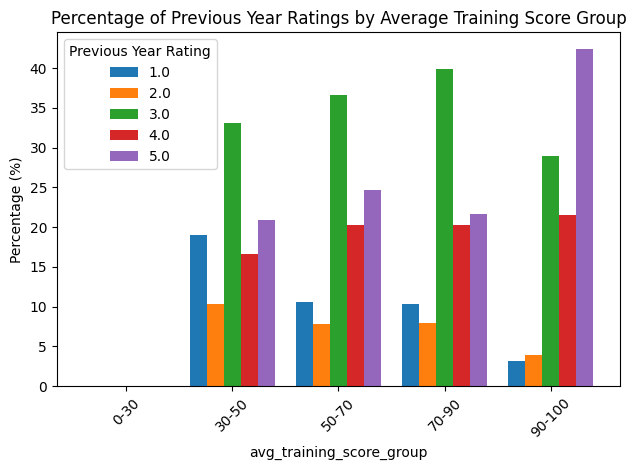

In [833]:
# Grouping by 'avg_training_score_group' and 'previous_year_rating'
rating_counts = df.groupby(['avg_training_score_group', 'previous_year_rating']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Previous Year Ratings by Average Training Score Group')
plt.xticks(rotation=45)
plt.legend(title='Previous Year Rating')
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\3426758696.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_counts = df.groupby(['avg_training_score_group', 'KPIs_met >80%']).size().unstack(fill_value=0)


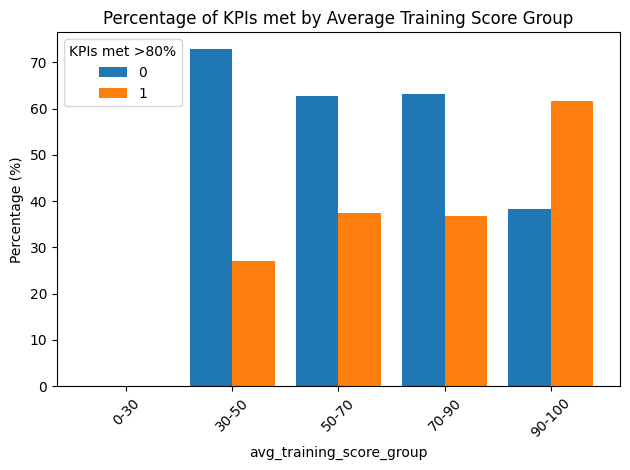

In [834]:
# Grouping by 'avg_training_score_group' and 'previous_year_rating'
rating_counts = df.groupby(['avg_training_score_group', 'KPIs_met >80%']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of KPIs met by Average Training Score Group')
plt.xticks(rotation=45)
plt.legend(title='KPIs met >80%')
plt.tight_layout()
plt.show()

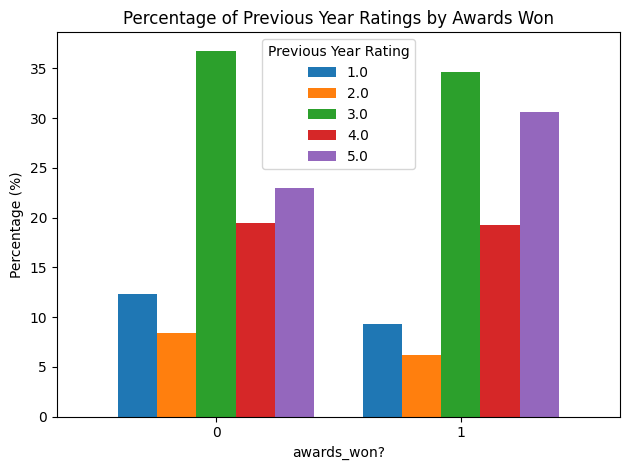

In [835]:
rating_counts = df.groupby(['awards_won?', 'previous_year_rating']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Previous Year Ratings by Awards Won')
plt.xticks(rotation=0)
plt.legend(title='Previous Year Rating', )  
plt.tight_layout()
plt.show()

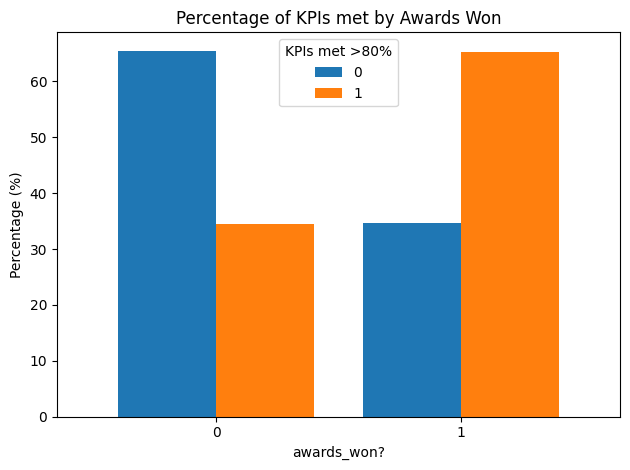

In [836]:
rating_counts = df.groupby(['awards_won?', 'KPIs_met >80%']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of KPIs met by Awards Won')
plt.xticks(rotation=0)
plt.legend(title='KPIs met >80%', )  
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\728549496.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_counts = df.groupby(['avg_training_score_group', 'awards_won?']).size().unstack(fill_value=0)


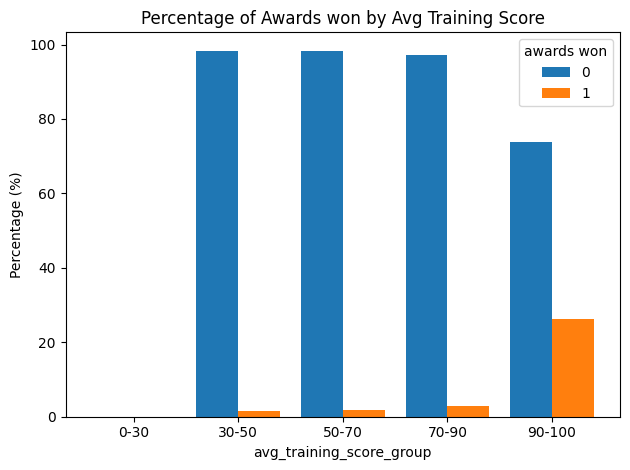

In [837]:
# Grouping by 'awards_won?' and 'avg_training_score_group'
score_counts = df.groupby(['avg_training_score_group', 'awards_won?']).size().unstack(fill_value=0)

# Calculate percentages
score_percentage = score_counts.div(score_counts.sum(axis=1), axis=0) * 100

# Plotting
score_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Awards won by Avg Training Score')
plt.xticks(rotation=0)
plt.legend(title='awards won')
plt.tight_layout()
plt.show()

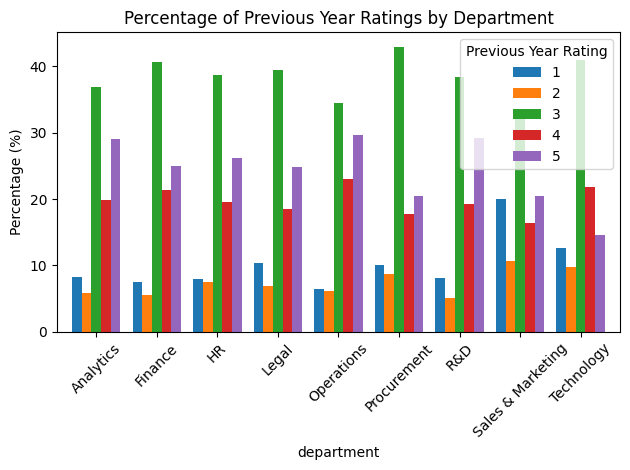

In [838]:
# Grouping by 'department' and 'previous_year_rating'
rating_counts = df.groupby(['department', 'previous_year_rating']).size().unstack(fill_value=0)

# Calculate percentages
rating_percentage = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Plotting
rating_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Previous Year Ratings by Department')
plt.xticks(rotation=45)
plt.legend(title='Previous Year Rating', labels=[str(i) for i in range(1,6)]) 
plt.tight_layout()
plt.show()

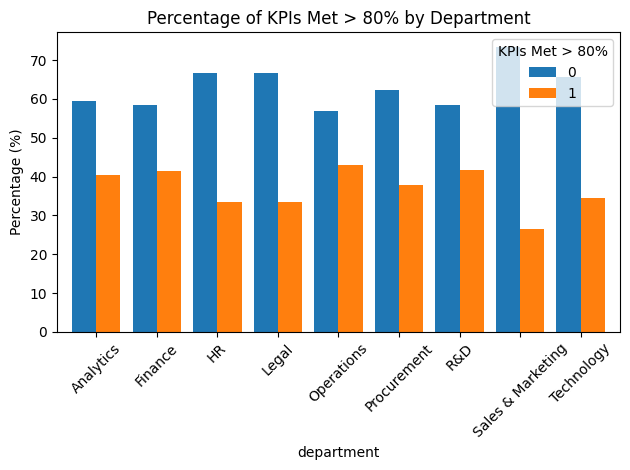

In [839]:
# Grouping by 'department' and 'KPIs_met >80%'
kpi_counts = df.groupby(['department', 'KPIs_met >80%']).size().unstack(fill_value=0)

# Calculate percentages
kpi_percentage = kpi_counts.div(kpi_counts.sum(axis=1), axis=0) * 100

# Plotting
kpi_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of KPIs Met > 80% by Department')
plt.xticks(rotation=45)
plt.legend(title='KPIs Met > 80%')
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\825873905.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  department_counts = df.groupby(['department', 'avg_training_score_group']).size().unstack(fill_value=0)


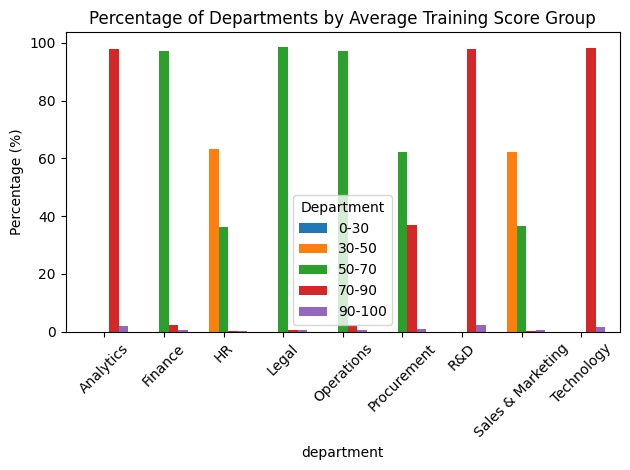

In [840]:
# Grouping by 'avg_training_score_group' and 'department'
department_counts = df.groupby(['department', 'avg_training_score_group']).size().unstack(fill_value=0)

# Calculate percentages
department_percentage = department_counts.div(department_counts.sum(axis=1), axis=0) * 100

# Plotting
department_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Departments by Average Training Score Group')
plt.xticks(rotation=45)
plt.legend(title='Department')
plt.tight_layout()
plt.show()

Target Variable Analysis

In [841]:
df['is_promoted'].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

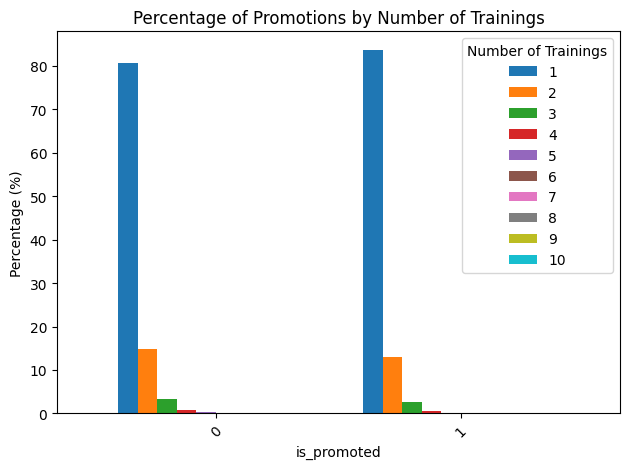

In [842]:
# Grouping by 'no_of_trainings' and 'is_promoted'
promotion_counts = df.groupby(['is_promoted', 'no_of_trainings']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Promotions by Number of Trainings')
plt.xticks(rotation=45)
plt.legend(title='Number of Trainings' )
plt.tight_layout()
plt.show()

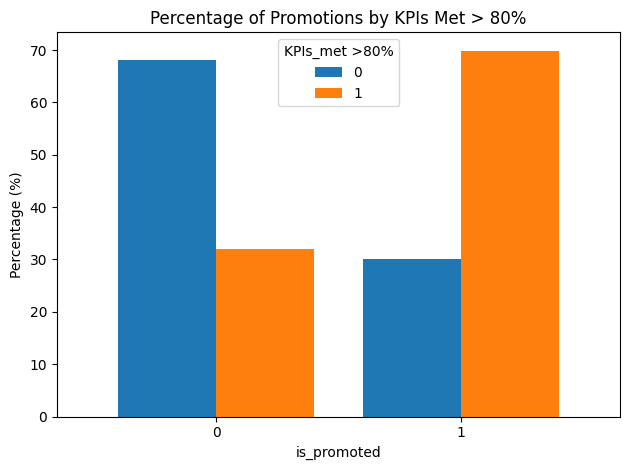

In [843]:
# Grouping by 'KPIs_met >80%' and 'is_promoted'
promotion_counts = df.groupby(['is_promoted', 'KPIs_met >80%']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Promotions by KPIs Met > 80%')
plt.xticks(rotation=0)
plt.legend(title='KPIs_met >80%')
plt.tight_layout()
plt.show()

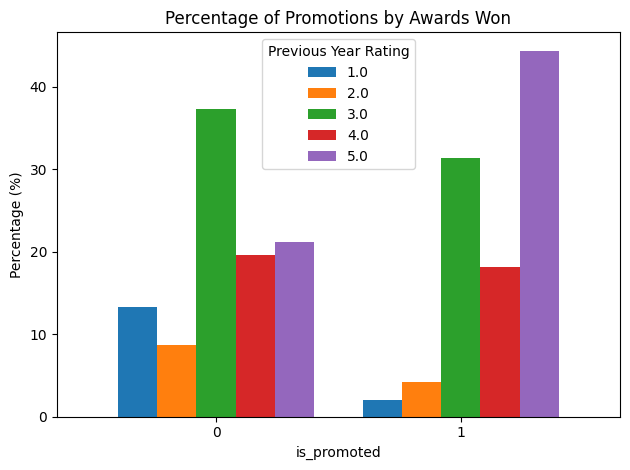

In [844]:
# Grouping by 'awards_won?' and 'is_promoted'
promotion_counts = df.groupby(['is_promoted', 'previous_year_rating']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Promotions by Awards Won')
plt.xticks(rotation=0)
plt.legend(title='Previous Year Rating')
plt.tight_layout()
plt.show()

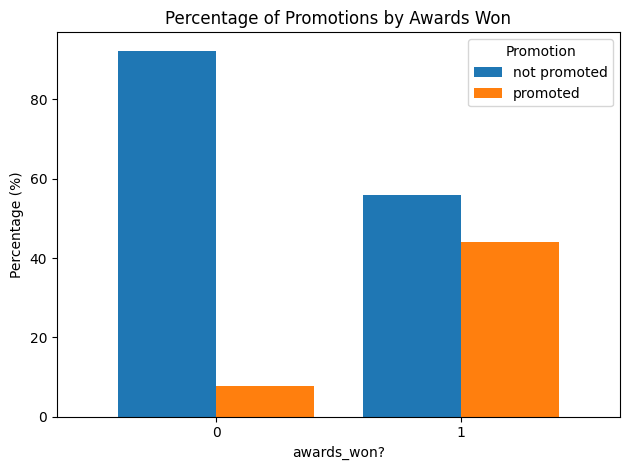

In [845]:
# Grouping by 'awards_won?' and 'is_promoted'
promotion_counts = df.groupby(['awards_won?', 'is_promoted']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Promotions by Awards Won')
plt.xticks(rotation=0)
plt.legend(title='Promotion', labels=['not promoted','promoted'])
plt.tight_layout()
plt.show()

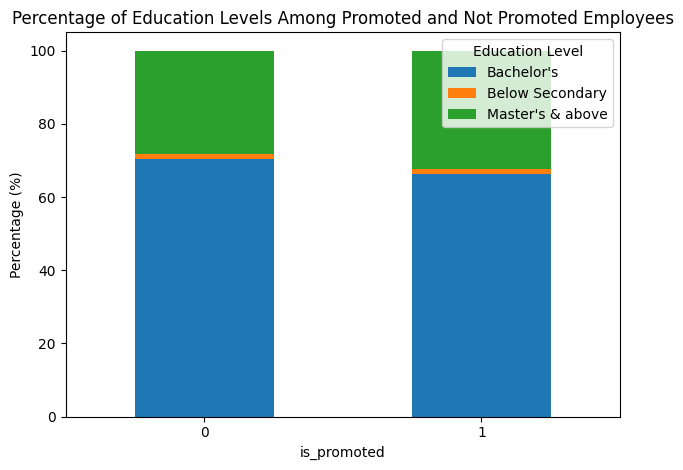

In [846]:
# Creating a crosstab and calculating percentages
promotion_crosstab = pd.crosstab(df['is_promoted'], df['education'])
promotion_percentage = promotion_crosstab.div(promotion_crosstab.sum(axis=1), axis=0) * 100

# Plotting the stacked bar chart
promotion_percentage.plot(kind='bar', stacked=True)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Education Levels Among Promoted and Not Promoted Employees')
plt.xticks(rotation=0)
plt.legend(title='Education Level')
plt.tight_layout()
plt.show()


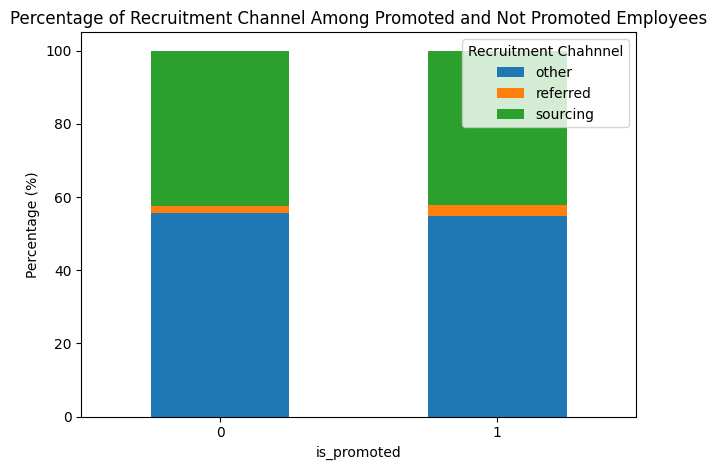

In [847]:
# Creating a crosstab and calculating percentages
promotion_crosstab = pd.crosstab(df['is_promoted'], df['recruitment_channel'])
promotion_percentage = promotion_crosstab.div(promotion_crosstab.sum(axis=1), axis=0) * 100

# Plotting the stacked bar chart
promotion_percentage.plot(kind='bar', stacked=True)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Recruitment Channel Among Promoted and Not Promoted Employees')
plt.xticks(rotation=0)
plt.legend(title='Recruitment Chahnnel')
plt.tight_layout()
plt.show()

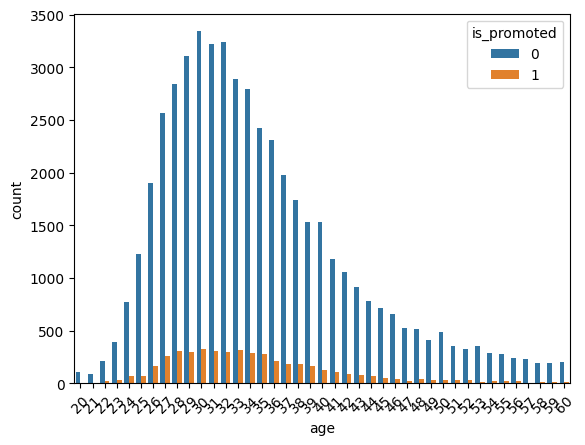

In [848]:
sns.countplot(x='age', hue='is_promoted', data=df)
plt.xticks(rotation=45)  
plt.show()

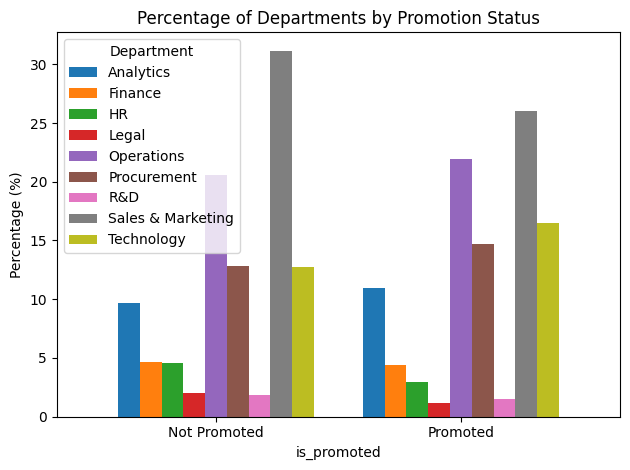

In [849]:
# Grouping by 'is_promoted' and 'department'
promotion_counts = df.groupby(['is_promoted', 'department']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Departments by Promotion Status')
plt.xticks(ticks=[0, 1], labels=['Not Promoted', 'Promoted'], rotation=0)
plt.legend(title='Department')
plt.tight_layout()
plt.show()

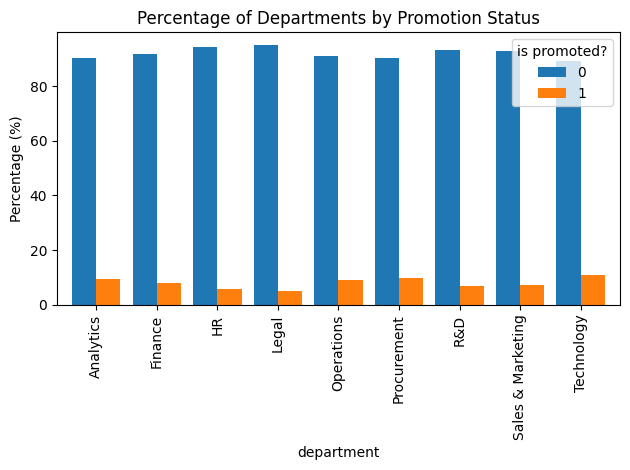

In [850]:
# Grouping by 'is_promoted' and 'department'
promotion_counts = df.groupby(['department', 'is_promoted']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Departments by Promotion Status')

plt.legend(title='is promoted?')
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\1786415901.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promotion_counts = df.groupby(['is_promoted', 'avg_training_score_group']).size().unstack(fill_value=0)


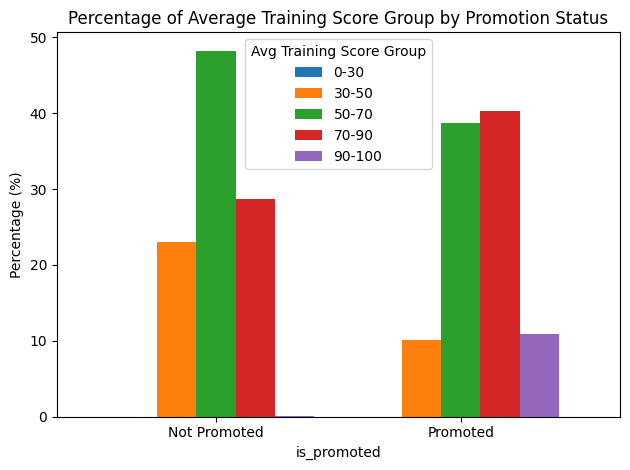

In [851]:
# Grouping by 'is_promoted' and 'avg_training_score_group'
promotion_counts = df.groupby(['is_promoted', 'avg_training_score_group']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Plotting
promotion_percentage.plot(kind='bar', width=0.8)
plt.ylabel('Percentage (%)')
plt.title('Percentage of Average Training Score Group by Promotion Status')

# Set x-ticks
plt.xticks(ticks=[0, 1], labels=['Not Promoted', 'Promoted'], rotation=0)
plt.legend(title='Avg Training Score Group')
plt.tight_layout()
plt.show()

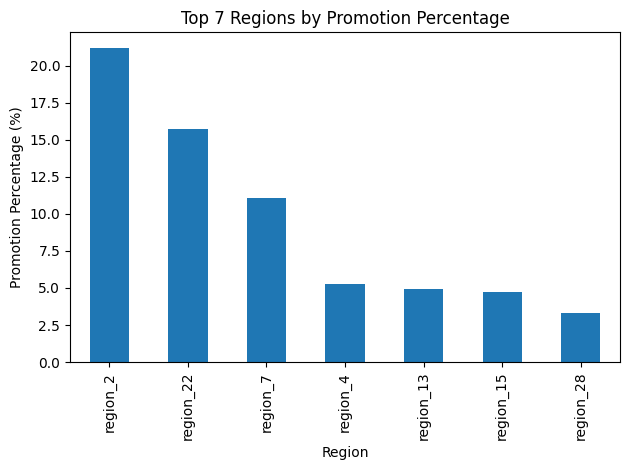

In [852]:
# Grouping by 'region' and 'is_promoted'
promotion_counts = df.groupby(['is_promoted', 'region']).size().unstack(fill_value=0)

# Calculate percentages
promotion_percentage = promotion_counts.div(promotion_counts.sum(axis=1), axis=0) * 100

# Select only the top 7 regions by promotion (is_promoted == 1)
top_7_promotions = promotion_percentage.loc[1].sort_values(ascending=False).head(7)
# Plot the top 7 regions
top_7_promotions.plot(kind='bar')
plt.xlabel('Region')
plt.ylabel('Promotion Percentage (%)')
plt.title('Top 7 Regions by Promotion Percentage')

# Show the plot
plt.tight_layout()
plt.show()

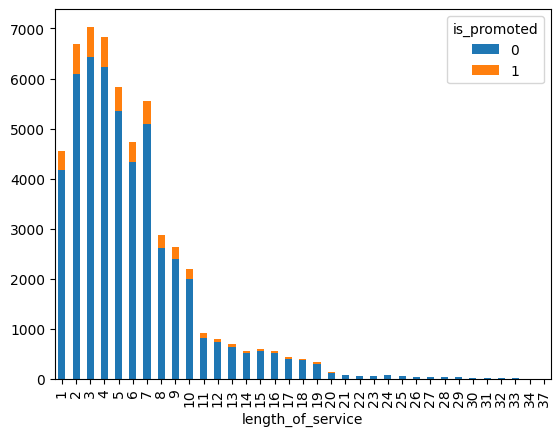

In [853]:
pd.crosstab(df['length_of_service'], df['is_promoted']).plot(kind='bar', stacked=True)
plt.show()

Feature Engineering

Take necessary actions for missing and outliers

In [854]:
df['previous_year_rating'].fillna(df['previous_year_rating'].mean(), inplace=True) #Missing values were filled with the mean.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\4158920703.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_year_rating'].fillna(df['previous_year_rating'].mean(), inplace=True) #Missing values were filled with the mean.


In [855]:
df['education'].fillna(df['education'].mode()[0], inplace=True) #Missing values were filled with the mode.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13060\2101119272.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].fillna(df['education'].mode()[0], inplace=True) #Missing values were filled with the mode.


In [856]:
df.isnull().sum()

employee_id                 0
department                  0
region                      0
education                   0
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating        0
length_of_service           0
KPIs_met >80%               0
awards_won?                 0
avg_training_score          0
is_promoted                 0
avg_training_score_group    0
dtype: int64

Capping outliers at a certain threshold:

In [857]:
df['age'] = df['age'].apply(lambda x: 54 if x >54 else x) 
#If a value in the 'age' column is greater than 54, it replaces it with 54; otherwise, it keeps the original value.


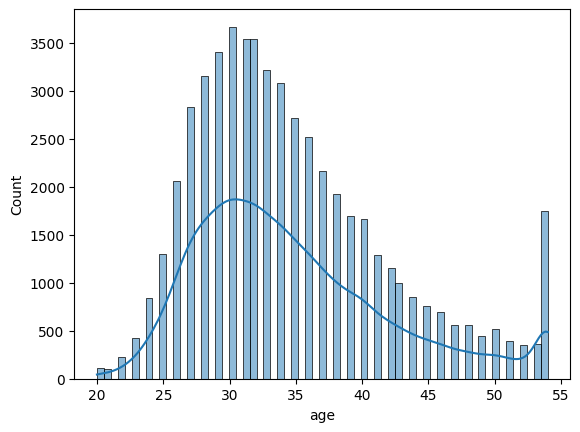

In [858]:
sns.histplot(df['age'], kde=True)
plt.show()

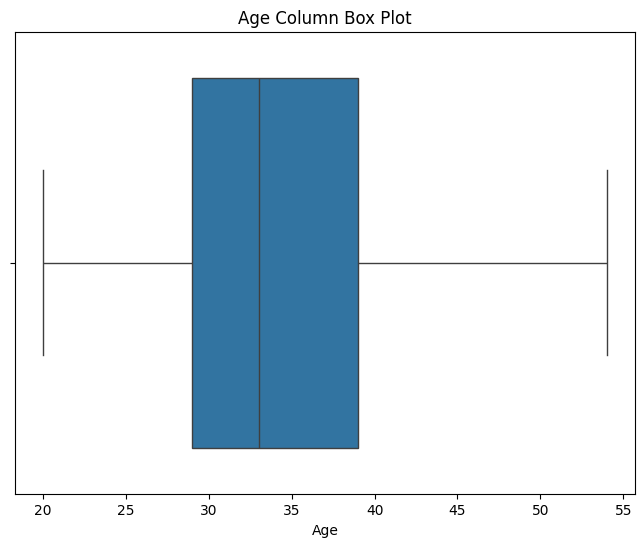

In [859]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['age'])
plt.title('Age Column Box Plot')
plt.xlabel('Age')
plt.show()

In [860]:
#If a value in the 'length_of_service' column is greater than 13, it replaces it with 13; otherwise, it keeps the original value.
df['length_of_service'] = df['length_of_service'].apply(lambda x: 13 if x > 13 else x)


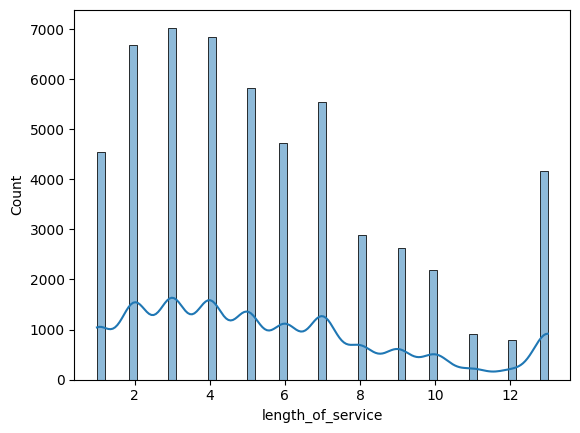

In [861]:
sns.histplot(df['length_of_service'], kde=True)
plt.show()

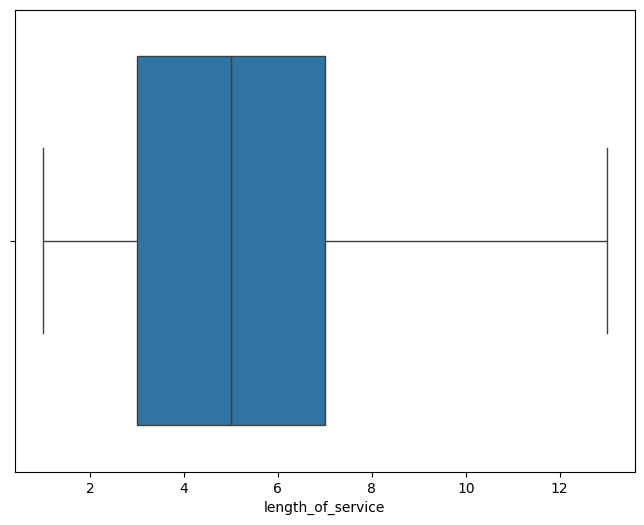

In [862]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['length_of_service'])
plt.show()

Encoding Data for Model Training

Label Encoding

-> Converts each category into a unique integer. However,it can introduce ordinal relationships between categories (e.g., 0 < 1 < 2)

In [863]:
le = LabelEncoder()
df['avg_training_score_encoded'] = le.fit_transform(df['avg_training_score_group'])

In [864]:
df.drop('avg_training_score_group', axis=1, inplace=True)

In [865]:
df['gender_encoded'] = le.fit_transform(df['gender'])

One Hot Encoding

->Converts each category into a binary column (0 or 1) for each unique category. It avoids ordinal relationships.

In [866]:
df_dummies_department = pd.get_dummies(df['department'], prefix='department')
df_dummies_department=df_dummies_department.astype(int)
df_dummies_region = pd.get_dummies(df['region'], prefix='region')
df_dummies_region=df_dummies_region.astype(int)
df_dummies_recruitment_channel = pd.get_dummies(df['recruitment_channel'], prefix='recruitment_channel')
df_dummies_recruitment_channel=df_dummies_recruitment_channel.astype(int)

df = pd.concat([df, df_dummies_department, df_dummies_region, df_dummies_recruitment_channel], axis=1)

In [867]:
df['previous_year_rating'] = df['previous_year_rating'].astype(int)

In [868]:
education_mapping = {
    "Master's & above": 2,
    "Bachelor's": 1,
    "Below Secondary": 0
}
#Converts categorical values ​​in the training column to corresponding numeric values.
df['education_encoded'] = df['education'].map(education_mapping)

In [869]:
df['regions'] = df['region'].apply(lambda x: x if x in ['region_2', 'region_22', 'region_7'] else 'other_region')
df['departments'] = df['department'].apply(lambda x: x if x in ['Sales & Marketing', 'Operations', 'Technology', 'Analytic','R&D'] else 'other_department')

df = pd.get_dummies(df, columns=['regions', 'departments'], drop_first=True)

for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

In [870]:
df.drop(columns=['education'], inplace=True)
df.drop(columns=['gender'], inplace=True)
df.drop(columns=['recruitment_channel'], inplace=True)
df.drop(columns=['avg_training_score'], inplace=True)
df.drop(columns=['region'], inplace=True)
df.drop(columns=['department'], inplace=True)

In [871]:
df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,is_promoted,avg_training_score_encoded,gender_encoded,...,recruitment_channel_referred,recruitment_channel_sourcing,education_encoded,regions_region_2,regions_region_22,regions_region_7,departments_R&D,departments_Sales & Marketing,departments_Technology,departments_other_department
0,65438,1,35,5,8,1,0,0,0,0,...,0,1,2,0,0,1,0,1,0,0
1,65141,1,30,5,4,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
2,7513,1,34,3,7,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,0
3,2542,2,39,1,10,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
4,48945,1,45,3,2,0,0,0,2,1,...,0,0,1,0,0,0,0,0,1,0


New Features for higher performance

In [872]:
df.columns = df.columns.str.replace(' ', '_')

In [873]:
df['KPI_rating_promoted'] = np.where((df['KPIs_met_>80%'] == 1) & (df['previous_year_rating'] >= 4) & (df['is_promoted'] == 1), 1, 0)


In [874]:
df['age_category'] = pd.cut(df['age'], bins=[0, 27, 37, df['age'].max()], labels=['below_27', '27_to_37', 'above_37']) #Group the age column according to the desired ranges.
df['age_category_encoded'] = le.fit_transform(df['age_category'])
df=df.drop('age_category',axis=1)
df.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_>80%,awards_won?,is_promoted,avg_training_score_encoded,gender_encoded,...,education_encoded,regions_region_2,regions_region_22,regions_region_7,departments_R&D,departments_Sales_&_Marketing,departments_Technology,departments_other_department,KPI_rating_promoted,age_category_encoded
0,65438,1,35,5,8,1,0,0,0,0,...,2,0,0,1,0,1,0,0,0,0
1,65141,1,30,5,4,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
2,7513,1,34,3,7,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
3,2542,2,39,1,10,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
4,48945,1,45,3,2,0,0,0,2,1,...,1,0,0,0,0,0,1,0,0,1


Preparing Features and Target Variable for Promotion Prediction Model

In [875]:
y = df['is_promoted']
x= df.drop(['employee_id', 'is_promoted'], axis=1)

Performance Evaluation Using Random Forest with Balanced Class Weights

In [876]:
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Model Creation
model = RandomForestClassifier(class_weight='balanced',random_state=42)


#Model Training
model.fit(X_train, y_train)

#Making Prediction
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9606823572340814

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     10054
           1       0.90      0.59      0.71       908

    accuracy                           0.96     10962
   macro avg       0.93      0.79      0.85     10962
weighted avg       0.96      0.96      0.96     10962

